# Γιάννης Δαλιάνης
# 1115201700027
# Homework 1
# Άσκηση 3

Imports

In [ ]:
import os
import re
from google.colab import drive
import pandas as pd
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import preprocessing

from matplotlib import pyplot as plt

import numpy as np
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mount Google Drive where the csv file is saved.

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'DI/Colab Notebooks/ex1'

Mounted at /content/gdrive


Drop uneccessary columns.

In [ ]:
tweets = pd.read_csv(base_dir + 'SentimentTweets.csv')

print(tweets.columns)

tweets = tweets.drop(['flag', 'date', 'user', 'Unnamed: 0', 'id'], axis=1)

tweets

Index(['Unnamed: 0', 'target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')


,target,text
0,0,#brokenpromises...
1,0,David Carradine so sad. Thai's law not sure i...
2,4,A @ 415 B @ 425. Tell your bro i say congrats!
3,4,@littlefluffycat Indeed.
4,4,Completed Race 4 Life in 58mins with girlies f...
...,...,...
1279995,4,@zawhtutwin watching cartoon and cry? oh i do ...
1279996,4,is eating mcdonalds
1279997,0,@BestSoyLatte So sorry to hear about your car....
1279998,4,@leesherry you have done what you could. Forgi...


Clean tweet text.

In [ ]:
tweets = tweets.apply(lambda x: x.astype(str).str.lower())

def cleanText(text):
    
    # Removing RT
    text = text.str.replace(r'RT[\s]+', '')

    # remove hashtags and mentions
    text = text.str.replace(r'#.*?(?=\s|$)', '')
    text = text.str.replace(r'@.*?(?=\s|$)', '')

    # remove urls
    text = text.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
    text = text.apply(lambda x: re.split('https:\/\/.*', str(x))[0])

    # remove newlines and other special characters
    text = text.replace(r'\\n',' ', regex=True)
    text = text.replace(r'\\u',' ', regex=True)
    text = text.replace(r'\\x',' ', regex=True)

    # remove all numbers
    text = text.str.replace('\d+', '')

    # remove words with 2 or 1 letter only
    text = text.str.replace(r'\b(\w{1,2})\b', '')

    # remove punctuations
    text = text.str.replace('[^\w\s]','')

    # replace multiple whitespaces
    text = text.apply(lambda x: re.sub(' +', ' ', x))

    return text

tweets['text'] = cleanText(tweets['text'])

# erase empty lines
nan_value = float("NaN")
tweets['text'].replace(" ", "", inplace=True)
tweets['text'].replace("", nan_value, inplace=True)
tweets.dropna(subset=['text'], inplace=True)

# 0 will be for negative and 1 for positive
tweets['target'] = tweets['target'].astype(int)
tweets['target'].replace(4, 1, inplace=True)

tweets

,target,text
1,0,david carradine sad thai law not sure fowl pla...
2,1,tell your bro say congrats
3,1,indeed
4,1,completed race life mins with girlies from wor...
5,0,woot truck fixed now workin
...,...,...
1279995,1,watching cartoon and cry that all the time ge...
1279996,1,eating mcdonalds
1279997,0,sorry hear about your carthat the definition ...
1279998,1,you have done what you could forgiveness proc...


Remove stopwords.

In [ ]:
def remove_stops(row):
  stops = nltk.corpus.stopwords.words("english")
  meaningful_words = [w for w in row if w not in stops]
  return meaningful_words

def rejoin_words(row):
  joined_words = ( " ".join(row))
  return joined_words

# takes some time
tweets["text"] = tweets["text"].str.split()
tweets['text'] = tweets['text'].apply(lambda x: remove_stops(x))
tweets['text'] = tweets['text'].apply(lambda x: rejoin_words(x))

# erase empty lines
nan_value = float("NaN")
tweets['text'].replace(" ", "", inplace=True)
tweets['text'].replace("", nan_value, inplace=True)
tweets.dropna(subset=['text'], inplace=True)

tweets

,target,text
1,0,david carradine sad thai law sure fowl play ma...
2,1,tell bro say congrats
3,1,indeed
4,1,completed race life mins girlies work fun bloo...
5,0,woot truck fixed workin
...,...,...
1279995,1,watching cartoon cry time gets easier lol cry ...
1279996,1,eating mcdonalds
1279997,0,sorry hear carthat definition bad news
1279998,1,done could forgiveness process realizing broke...


Function that separates Train and Test Data and Encodes Labels.

In [ ]:
data = tweets["text"]
Labels = tweets["target"]

def MakeSets(data, Labels, test_size=0.2):
  Train_X, Test_X, Train_Y, Test_Y = train_test_split(data, Labels, test_size=test_size)

  Encoder = LabelEncoder()
  Train_Y = Encoder.fit_transform(Train_Y)
  Test_Y = Encoder.fit_transform(Test_Y)

  return Train_X, Test_X, Train_Y, Test_Y

CountVectorizer of tweets.

In [ ]:
vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 1),
    dtype='double'
)

data = vectorizer.fit_transform(data)

min_max_scaler = MaxAbsScaler ()
data = min_max_scaler.fit_transform(data)
data = preprocessing.scale(data, with_mean=False)


Train_X, Test_X, Train_Y, Test_Y = MakeSets(data, Labels)

Get best parameters by computing grid search on random data. Makes numerous computations on very large data and takes a lot of time.

In [ ]:
randomCheckData, _, randomCheckLabels, _ = MakeSets(data[:10000], Labels[:10000], 0.985)

param_grid = [
    { 
      'penalty': ['l2'],
      'solver': ['lbfgs', 'liblinear', 'saga'],
      'C': [0.01, 0.1, 1, 10],
      'multi_class': ['auto', 'ovr'],
      'max_iter': [8000, 10000],
      'class_weight': ['balanced', None]
    }
  ]

logisticRegr = LogisticRegression()

grid_search = GridSearchCV(logisticRegr, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

start_time = time.time()

grid_search.fit(randomCheckData, randomCheckLabels)

print("--- %.2f seconds ---" % (time.time() - start_time))

print("Best parameters are ", grid_search.best_params_)
print("Best estimator is ", grid_search.best_estimator_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

--- 4670.66 seconds ---
Best parameters are  {'C': 1, 'class_weight': 'balanced', 'max_iter': 8000, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
Best estimator is  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=8000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.6879922480183431 {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 8000, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
0.725718035235908 {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 8000, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear'}
0.7438637868140466 {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 8000, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'saga'}
0.6879922480183431 {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 8000, 'mul

Execution with optimized model.

Precision Score ->  74.60583665729273
Recall Score ->  74.63691859275379
F-Measure Score ->  74.59970410639133


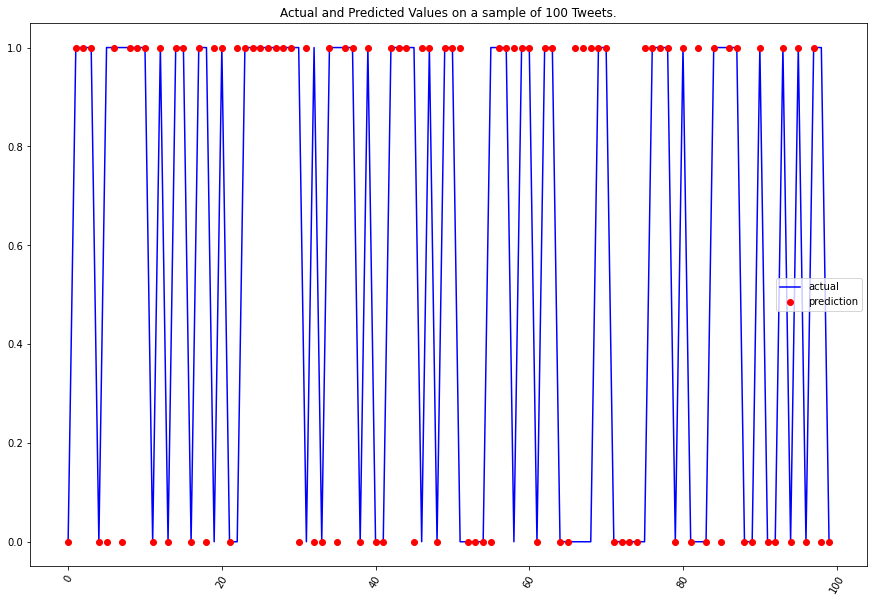

In [ ]:
logisticRegr = grid_search.best_estimator_

logisticRegr.fit(Train_X, Train_Y)

predicted = logisticRegr.predict(Test_X)

score = logisticRegr.score(Test_X, Test_Y)

print("Precision Score -> ",precision_score(predicted, Test_Y, average='macro')*100)
print("Recall Score -> ",recall_score(predicted, Test_Y, average='macro')*100)
print("F-Measure Score -> ",f1_score(predicted, Test_Y, average='macro')*100)

fig = plt.figure(figsize=[15,10])

# Plot the actual values
plt.plot(Test_Y[:100], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predicted[:100], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
plt.title('Actual and Predicted Values on a sample of 100 Tweets.');
plt.show()